# Introduction


WFC3/IR filters F105W and F110W are sensitive to Helium I emission from the Earth's atmosphere. This effect the ramps taken closest in time to Earth occultation, either in the last few ramps at the end of an orbit (entering occultation) or in the first few ramps at the beginning of an orbit (exiting occultation). 

This produces an flat background signal which is added to the sky in a subset of the IR ramps, and this non-linear background may compromise the ramp fitting step performed by calwf3, which is designed to flag and remove cosmic rays and saturation. The calibrated FLT data products will be lower signal-to-noise than expected, with a strongly non-gaussian sky background. 

This notebook demonstrates how to diagnose and correct for a non-linear background in IR frames. It was based on python code to 'Flatten' the IR ramps, provided in WFC3 ISR 2016-16: [Reprocessing WFC3/IR Exposures Affected by Time-Variable Backgrounds](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2016-16.pdf).

>The notebook is organized as follows:
>
>1. Download the data from MAST and reference files from CRDS
>2. Diagnose which FLT datasets may have poor ramp fitting
>3. Recalibrate the RAW files with ramp-fitting (CRCORR) turned off
>4. Subtract the median background per read in the IMA file
>5. Resume calwf3 on corrected IMA file, with ramp-fitting turned on 


# Setup

This notebook assumes you have installed a recent version of [AstroConda](https://astroconda.readthedocs.io) . 

Two additional astropy packages must be installed in your conda environment before downloading the data. To do this, type the following command in the terminal before starting the notebook:

>conda install -c astropy astroquery ccdproc

In [304]:
from ccdproc import ImageFileCollection
from astroquery.mast import Observations
from astropy.io import fits

import matplotlib.pyplot as plt
import numpy as np
import wfc3tools
import os 
import glob 
import shutil

# Data

The following commands query MAST for the necessery products and then download them to the current directory.

Here we obtain WFC3/IR observations from CANDELs program 12242, Visit BF. The data products requested are the ASN, RAW, IMA and FLT files.

In [ ]:
data_list = Observations.query_criteria(obs_id='IBOHBF*')
Observations.download_products(data_list['obsid'],mrp_only=False,download_dir='./data',
                               productSubGroupDescription=['ASN','RAW','IMA','FLT'])

science_files = glob.glob('data/mastDownload/HST/*/*fits')

for im in science_files:
    root = im.split('/')[-1]
    os.rename(im,'./'+root)
shutil.rmtree('data/')

# Observation Summary 

The WFC3 association for visit BF 'ibohbf040_asn.fits' comprises a single visit over 3 orbits with six consecutive exposures in F105W. 

Each orbit consists of two back-to-back 1600 sec exposures, followed by the Earth occultation. 

In [306]:
collec = ImageFileCollection('./',
                             keywords=["asn_id","targname","filter","samp_seq","nsamp","exptime",
                             "postarg1","postarg2","date-obs","time-obs",], glob_include="*flt.fits", ext=0)
out_table = collec.summary
out_table

file,asn_id,targname,filter,samp_seq,nsamp,exptime,postarg1,postarg2,date-obs,time-obs
str18,str9,str12,str5,str7,int64,float64,float64,float64,str10,str8
ibohbfb7q_flt.fits,IBOHBF040,GOODN-N1-VBF,F105W,STEP200,16,1599.23291,-0.237,-0.212,2013-01-06,18:23:01
ibohbfb9q_flt.fits,IBOHBF040,GOODN-N1-VBF,F105W,STEP200,16,1599.23291,0.305,-0.03,2013-01-06,18:50:42
ibohbfbdq_flt.fits,IBOHBF040,GOODN-N1-VBF,F105W,STEP200,16,1599.23291,0.102,0.273,2013-01-06,19:18:23
ibohbfbgq_flt.fits,IBOHBF040,GOODN-N1-VBF,F105W,STEP200,16,1599.23291,-0.44,0.091,2013-01-06,19:48:08
ibohbfbkq_flt.fits,IBOHBF040,GOODN-N1-VBF,F105W,STEP200,16,1599.23291,0.237,0.212,2013-01-06,20:15:49
ibohbfbpq_flt.fits,IBOHBF040,GOODN-N1-VBF,F105W,STEP200,16,1599.23291,0.779,0.394,2013-01-06,20:43:30


# Identify Exposures with Non-linear Background

In this notebook, we will focus only on the first two exposures in the visit, which make up a single orbit. The first exposure ibohbfb7q is not impacted, and the second exposure ibohbfb9q suffers from additional background at the end of the exposure. 

While additional exposures in this visit were also impacted by non-linear background, only the first two are discussed in this notebook for brevity. 

There are several ways to diagnose a poor ramp fit in the calibrated data products:

    1.) Display the FLT images and look for unusually large noise
    2.) Plot a histogram of the sky background in the FLT and look for a non-gaussian distribution  
    3.) Plot the median background of each ramp in the IMA file and look for non-linearity

# Display the Images

An FLT exposure with a poor ramp fit will looks much noisier than a similar FLT exposure with a good ramp fit. 

Text(0.5,1,'ibohbfb9q_flt')

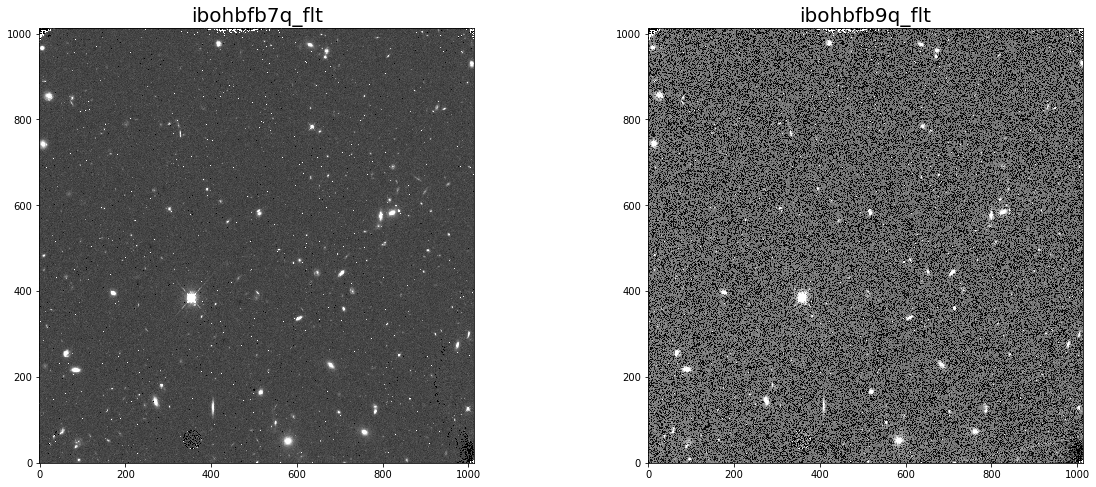

In [317]:
flt1=fits.getdata('ibohbfb7q_flt.fits',ext=1)
flt2=fits.getdata('ibohbfb9q_flt.fits',ext=1)

fig=plt.figure(figsize=(20,8))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

ax1.imshow(flt1, vmin=0.25,vmax=1.25,cmap='Greys_r',origin='lower')
ax2.imshow(flt2, vmin=1.25,vmax=2.25,cmap='Greys_r',origin='lower')

ax1.set_title('ibohbfb7q_flt',fontsize=20)
ax2.set_title('ibohbfb9q_flt',fontsize=20)

# Plot a Histogram of the Background

The impacted FLT exposure will typically have a non-gaussian background, often with a double peak and a large sigma.

Text(0.5,1,'ibohbfb9q_flt')

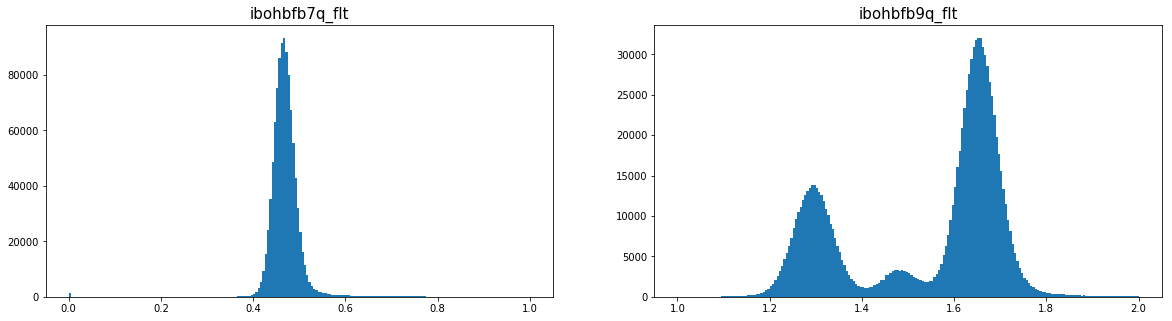

In [324]:
flt1f = flt1.flatten()
flt2f = flt2.flatten()

fig=plt.figure(figsize=(20,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

n, bins, patches = ax1.hist(flt1f,bins=200,range=(0,1))
n, bins, patches = ax2.hist(flt2f,bins=200,range=(1,2))

ax1.set_title('ibohbfb7q_flt',fontsize=15)
ax2.set_title('ibohbfb9q_flt',fontsize=15)

# Inspect the IR ramps
Using the task 'pstat' in wfc3tools, we compute statistics 'up the stack' of each IR MultiAccum image. Because the target is mostly 'blank' sky, the midpoint of each ramp is a good representation of the total background.

### ibohbfb7q 
In the first exposure, the median signal accumulates linearly over the exposure. 

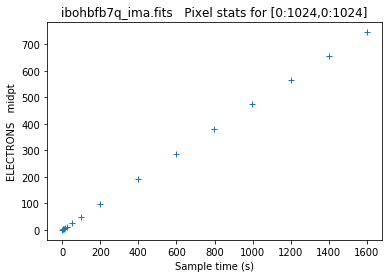

In [325]:
time1,counts1=wfc3tools.pstat('ibohbfb7q_ima.fits',stat='midpt',units='counts')

The median count rate is ~flat at ~0.5 electrons/sec. 

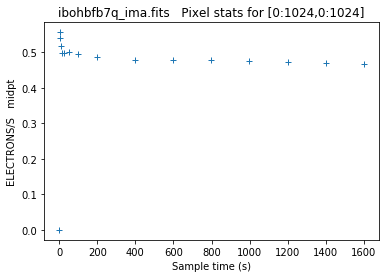

In [326]:
time1,rate1  =wfc3tools.pstat('ibohbfb7q_ima.fits',stat='midpt',units='rate')

###  ibohbfb9q 
In the second exposure, the median signal is non-linear over the exposure. 

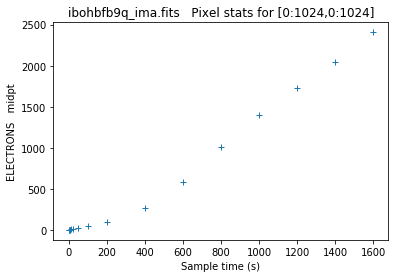

In [328]:
time2,counts2=wfc3tools.pstat('ibohbfb9q_ima.fits',stat='midpt',units='counts')

The median count rate varies by nearly a factor of 3, from ~0.5 e/s at the beginning of the exposure to ~1.5 e/s at the end of the exposure. 

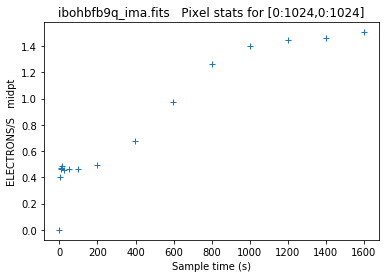

In [329]:
time2,rate2  =wfc3tools.pstat('ibohbfb9q_ima.fits',stat='midpt',units='rate')

# Recalibrate the data

Here we recalibrate the raw data using calwf3, with the 'ramp fitting' step turned off.
Next we remove the median background per read from the resulting IMA file.
Finally, we rerun calwf3 on the corrected IMA, with 'ramp fitting' turned on, in order to properly flag and reject cosmic rays.

First, we set environment variables define a path to the reference files 

In [330]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['IREF'] = './crds_cache/references/hst/wfc3/'
os.environ['iref'] = './crds_cache/references/hst/wfc3/'

Next, we download the 'bestrefs' for these RAW files

In [ ]:
raw_files = glob.glob('*_raw.fits')

for fil in raw_files:
    !crds bestrefs --files $fil --sync-references=1 --update-bestrefs

Run calwf3 on the affected file, setting CRCORR=OMIT to perform all steps except the ramp fitting.

In [ ]:
os.rename('ibohbfb9q_ima.fits', 'ibohbfb9q_ima_orig.fits')
os.rename('ibohbfb9q_flt.fits', 'ibohbfb9q_flt_orig.fits')

raw_file = 'ibohbfb9q_raw.fits'
raw=fits.open(raw_file,mode='update')
raw[0].header['CRCORR'] ='OMIT'
raw.flush()

wfc3tools.calwf3(raw_file )

os.rename('ibohbfb9q_flt.fits', 'ibohbfb9q_flt_norampfit.fits')

# Remove Median background per read from the IMA

In [337]:
ima = fits.open(raw_file.replace('raw','ima'), mode ='update')

### You can define a subregion for stats. Here we use the whole image, minus the 5 pixel wide overscan regions
stats_region =[[5,1014], [5,1014]]
slx = slice(stats_region[0][0], stats_region[0][1])
sly = slice(stats_region[1][0], stats_region[1][1])

### Subtract the median countrate from each read and add back the full exposure countrate to preserve pixel statistics
   
total_countrate = np.median(ima['SCI',1].data[sly, slx])
    
for i in range(ima[0].header['NSAMP'] -2):
    med = np.median(ima['SCI',i+1].data[sly, slx])
    ima['SCI',i+1].data += total_countrate - med
    print('%s, [SCI,%d], median_bkg: %.2f' %(raw_file, i+1, med))    
    
## Turn back on the ramp fitting for running calwf3 in the next step
ima[0].header['CRCORR'] ='PERFORM'

### Write the updated IMA
ima.flush()   

ibohbfb9q_raw.fits, [SCI,1], median_bkg: 1.51
ibohbfb9q_raw.fits, [SCI,2], median_bkg: 1.46
ibohbfb9q_raw.fits, [SCI,3], median_bkg: 1.44
ibohbfb9q_raw.fits, [SCI,4], median_bkg: 1.40
ibohbfb9q_raw.fits, [SCI,5], median_bkg: 1.26
ibohbfb9q_raw.fits, [SCI,6], median_bkg: 0.98
ibohbfb9q_raw.fits, [SCI,7], median_bkg: 0.68
ibohbfb9q_raw.fits, [SCI,8], median_bkg: 0.50
ibohbfb9q_raw.fits, [SCI,9], median_bkg: 0.47
ibohbfb9q_raw.fits, [SCI,10], median_bkg: 0.47
ibohbfb9q_raw.fits, [SCI,11], median_bkg: 0.46
ibohbfb9q_raw.fits, [SCI,12], median_bkg: 0.49
ibohbfb9q_raw.fits, [SCI,13], median_bkg: 0.47
ibohbfb9q_raw.fits, [SCI,14], median_bkg: 0.48


Recall that the extension [SCI,1] is the last read in the IMA file. These numbers show that the increased background signal occurred in the middle and at the end of the b9q exposure, just prior to Earth occultation, where the countrate is a factor of 3 larger than at the beginning of the exposure.

# Resume calwf3 

Run calwf3 on the cleaned IMA with only the CRCORR step turned on. This produces a corrected IMA and FLT image.

In [ ]:
wfc3tools.calwf3(raw_file.replace('raw','ima'))

### Clean up and rename files
os.remove('ibohbfb9q_ima.fits')
os.rename('ibohbfb9q_ima_ima.fits','ibohbfb9q_ima.fits')
os.rename('ibohbfb9q_ima_flt.fits','ibohbfb9q_flt.fits')

# Compare the Original and Corrected FLT products to the non-effected dataset

Text(0.5,1,'ibohbfb9q (Corrected)')

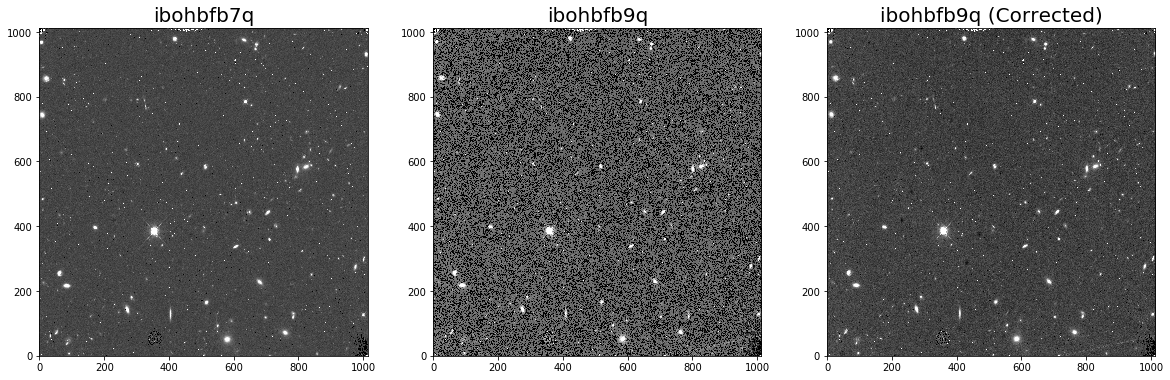

In [346]:
##Display the images
flt1    =fits.getdata('ibohbfb7q_flt.fits'     ,ext=1)
flt2    =fits.getdata('ibohbfb9q_flt_orig.fits',ext=1)
flt2corr=fits.getdata('ibohbfb9q_flt.fits'     ,ext=1)

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(1,3,1)
ax2=fig.add_subplot(1,3,2)
ax3=fig.add_subplot(1,3,3)

ax1.imshow(flt1,    vmin=0.25,vmax=1.25,cmap='Greys_r',origin='lower')
ax2.imshow(flt2,    vmin=1.30,vmax=2.30,cmap='Greys_r',origin='lower')
ax3.imshow(flt2corr,vmin=1.30,vmax=2.30,cmap='Greys_r',origin='lower')

ax1.set_title('ibohbfb7q' ,fontsize=20)
ax2.set_title('ibohbfb9q' ,fontsize=20)
ax3.set_title('ibohbfb9q (Corrected)',fontsize=20)

Text(0.5,1,'ibohbfb9q (Corrected)')

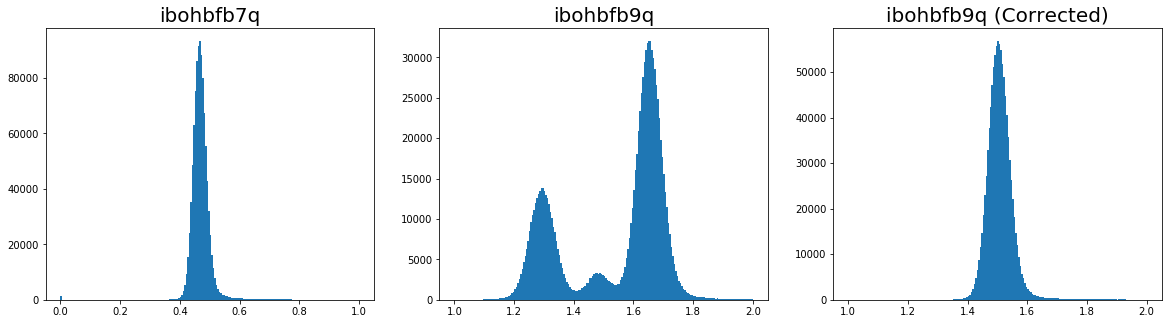

In [348]:
### Plot the histograms
flt1f     = flt1.flatten()
flt2f     = flt2.flatten()
flt2fcorr = flt2corr.flatten()

fig=plt.figure(figsize=(20,5))
ax1=fig.add_subplot(1,3,1)
ax2=fig.add_subplot(1,3,2)
ax3=fig.add_subplot(1,3,3)

n, bins, patches = ax1.hist(flt1f,    bins=200,range=(0,1))
n, bins, patches = ax2.hist(flt2f,    bins=200,range=(1,2))
n, bins, patches = ax3.hist(flt2fcorr,bins=200,range=(1,2))

ax1.set_title('ibohbfb7q',fontsize=20)
ax2.set_title('ibohbfb9q',fontsize=20)
ax3.set_title('ibohbfb9q (Corrected)',fontsize=20)

# Compare the background noise

In [352]:
w=np.where((0. < flt1f) & (flt1f < 1.))
flt1_mean=  np.mean(flt1f[w])
flt1_med =np.median(flt1f[w])
flt1_std =   np.std(flt1f[w])

w=np.where((1. < flt2f) & (flt2f < 2.))
flt2_mean=  np.mean(flt2f[w])
flt2_med =np.median(flt2f[w])
flt2_std =   np.std(flt2f[w])

w=np.where((1. < flt2fcorr) & (flt2fcorr < 2.))
flt2f_mean=  np.mean(flt2fcorr[w])
flt2f_med =np.median(flt2fcorr[w])
flt2f_std =   np.std(flt2fcorr[w])

print('%s'                     %('RAMP         Filename                  Mean    Median  Stdev') )
print('%s  %.3f   %.3f   %.3f' %('Linear       ibojbfb7q_flt          ',flt1_mean, flt1_med, flt1_std))    
print('%s  %.3f   %.3f   %.3f' %('Non-Linear   ibojbfb9q_flt_orig.fits',flt2_mean, flt2_med, flt2_std))    
print('%s  %.3f   %.3f   %.3f' %('Corrected    ibojbfb9q_flt.fits     ',flt2f_mean,flt2f_med,flt2f_std)) 

RAMP         Filename                  Mean    Median  Stdev
Linear       ibojbfb7q_flt            0.471   0.467   0.039
Non-Linear   ibojbfb9q_flt_orig.fits  1.542   1.625   0.170
Corrected    ibojbfb9q_flt.fits       1.508   1.505   0.047


----
The standard deviation of the background in corrected b9q FLT file has improved by nearly a factor of 4, compared to the original pipeline product. This value is now similar to the background standard deviation in the b7q FLT file taken in the first half of the orbit, which had a linear background.

Below we plot the original and the corrected ramps for exposure b9q and show how the signal is now linear. 

(0.4, 2.0)

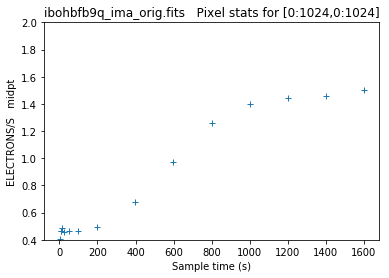

In [363]:
##Plot the original ramp
time,rate=wfc3tools.pstat('ibohbfb9q_ima_orig.fits',stat='midpt',units='rate')
plt.ylim(0.4,2.0)

(0.4, 2.0)

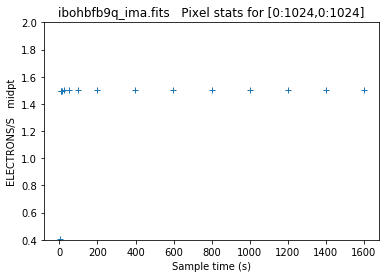

In [361]:
##Plot the corrected ramp
time,rate=wfc3tools.pstat('ibohbfb9q_ima.fits',stat='midpt',units='rate')
plt.ylim(0.4,2.0)

# Morphology

The improved FLT products can be particularly important for studies of faint, extended sources. 

The cutouts below show a ~200x200 subsection (~25x25") of the original and corrected FLT data product.

Text(0.5,1,'ibohbfb9q_flt_corr')

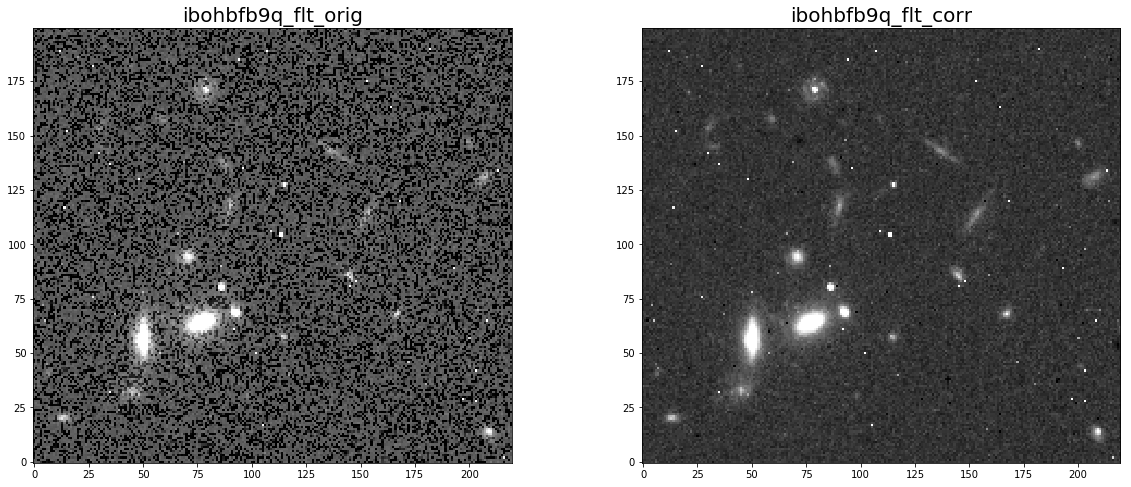

In [356]:
##Display the images
flt2    =fits.getdata('ibohbfb9q_flt_orig.fits',ext=1)
flt2corr=fits.getdata('ibohbfb9q_flt.fits',ext=1)

fig=plt.figure(figsize=(20,8))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

ax1.imshow(    flt2[520:720,750:970], vmin=1.3,vmax=2.5,cmap='Greys_r',origin='lower')
ax2.imshow(flt2corr[520:720,750:970], vmin=1.3,vmax=2.5,cmap='Greys_r',origin='lower')

ax1.set_title('ibohbfb9q_flt_orig',fontsize=20)
ax2.set_title('ibohbfb9q_flt_corr',fontsize=20)

# Summary

The corrected FLT files may now be used directly with DrizzlePac tools such as TweakReg and AstroDrizzle to align and combine multiple images.


# About this Notebook

    Author: J. Mack, STScI WFC3 Team
    Updated: September 2018